In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable tensorflow GPU

import sys
sys.path.insert(0, "src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dataset.CubiCasaDatset import CubiCasaDatset
from deeplearning.semantic_segmentation.UNet.UNet import UNetModelBuilder
from deeplearning.semantic_segmentation.Fast_SCNN.Fast_SCNN import Fast_SCNNBuilder
from processing.ocr import TesseractOCR
from processing.image_to_walls import ImageToWalls
from processing.objects_from_detections import process_openings_from_detections

from PIL import Image, ImageOps
from six import BytesIO
import cv2
import pickle 
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

from shapely.geometry import LineString, Polygon

In [3]:
%matplotlib inline

In [4]:
image_size = 848

In [5]:
# Define U-Net
mb = UNetModelBuilder(False)
model = mb.build_model(image_size=image_size)
model.compile(loss="binary_crossentropy")
model.load_weights('weights/unet/model_848.h5')

In [6]:
# Re-init object detection model (faster_rcnn)
# Reload model
pipeline_config_path = "weights/faster_rcnn/stored_model/pipeline.config"
checkpoint_path = "weights/faster_rcnn/stored_model/checkpoint/ckpt-0"

configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(checkpoint_path)

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

#map labels for inference decoding
label_map_path = "src/deeplearning/object_detection/tf_object_detection_api/openings_label_map.pbtxt"
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [7]:
def open_and_resize_image(path):
    im = Image.open(path)
    old_size = im.size
    ratio = float(image_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (image_size, image_size), (255, 255, 255))
    new_im.paste(im, ((image_size-new_size[0])//2,
                        (image_size-new_size[1])//2))
    
    new_im = ImageOps.grayscale(new_im)
    new_im =  np.array(new_im, dtype=int)
    return np.stack((new_im,new_im,new_im),axis=2)


In [8]:
def process_image(src):
    """
    Process floor plan 
    
    Parameters
    ----------
    src : str
        String
    """
    
    # open image
    to_predict_image = open_and_resize_image(src)
    
    # predict walls
    y_pred = model.predict(np.expand_dims(to_predict_image[:,:,0], axis=0))[0] > 0.5
    
    # morphological operations using OpenCV 
    image = y_pred.copy()
    
    # get walls 
    image_to_walls = ImageToWalls(image_size=image_size,kernel_size=15)
    walls = image_to_walls.do_steps(image)
    
    # get openings 
    image_np = to_predict_image.copy()
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    openings = process_openings_from_detections(detections, walls, image_size)
    
    # get labels 
    ocr = TesseractOCR()
    labels = ocr.extract_labels(to_predict_image)

    return {
            "input":to_predict_image,
            "walls":walls,
            "openings":openings,
            "labels": labels
    }


In [ ]:
%%time
# Cubicasa Samples
for file in os.listdir('input/cubicasa5k_samples'):
    
    # Do processing
    processed = process_image(f'input/cubicasa5k_samples/{file}')
    walls, openings, labels = processed['walls'], processed['openings'], processed['labels']
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.imshow(processed["input"], cmap="gray")
    for wall in walls: 
        ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1],color="grey")
        ax2.plot(wall.exterior.xy[0],wall.exterior.xy[1],color="blue",linewidth=0.5)

    for opening in openings:
        opening_poly = opening['polygon']
        ax2.fill(opening_poly.exterior.xy[0],opening_poly.exterior.xy[1],
                 color="red" if opening['type'] == "door" else "blue")

        center = opening_poly.centroid
        center = [center.xy[0][0], center.xy[1][0]]

        # direction: top, right, bottom, left
        if opening['direction'] != None:
            center[1] = center[1] - 20 if opening['direction'] == 0 else center[1]
            center[0] = center[0] + 20 if opening['direction'] == 1 else center[0]
            center[1] = center[1] + 20 if opening['direction'] == 2 else center[1]
            center[0] = center[0] - 20 if opening['direction'] == 3 else center[0]    

            ax2.scatter([center[0]], [center[1]],color="red", s=30)
    
    # Add labels
    for label in labels:
        mx = (label[1][2]+label[1][0])/2
        my = (label[1][3]+label[1][1])/2
        ax2.text(mx,my, label[0])

    # Show final result
    ax1.set_ylim(image_size,0)
    ax2.set_ylim(image_size,0)
    ax2.set_xlim(0,image_size)
    

In [ ]:
# Dutch Samples
for file in os.listdir('input/dutch_samples'):
    processed = process_image(f'input/dutch_samples/{file}')
    walls, openings, labels = processed['walls'], processed['openings'], processed['labels']

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.imshow(processed["input"], cmap="gray")
    for wall in walls: 
        ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1],color="grey")
        ax2.plot(wall.exterior.xy[0],wall.exterior.xy[1],color="blue",linewidth=0.5)

    for opening in openings:
        opening_poly = opening['polygon']
        ax2.fill(opening_poly.exterior.xy[0],opening_poly.exterior.xy[1],
                 color="red" if opening['type'] == "door" else "blue")

        center = opening_poly.centroid
        center = [center.xy[0][0], center.xy[1][0]]

        # direction: top, right, bottom, left
        if opening['direction'] != None:
            center[1] = center[1] - 20 if opening['direction'] == 0 else center[1]
            center[0] = center[0] + 20 if opening['direction'] == 1 else center[0]
            center[1] = center[1] + 20 if opening['direction'] == 2 else center[1]
            center[0] = center[0] - 20 if opening['direction'] == 3 else center[0]    

            ax2.scatter([center[0]], [center[1]],color="red", s=30)
   
    # Add labels
    for label in labels:
        mx = (label[1][2]+label[1][0])/2
        my = (label[1][3]+label[1][1])/2
        ax2.text(mx,my, label[0])

    # Show final result
    ax1.set_ylim(image_size,0)
    ax2.set_ylim(image_size,0)
    ax2.set_xlim(0,image_size)
    
    

In [ ]:
# BAG ID = 0200100000532701

for file_name in ['input/0200100000532701/1.png', 'input/0200100000532701/2.png']:
    processed = process_image(file_name)
    walls, openings, labels = processed['walls'], processed['openings'], processed['labels']

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.imshow(processed["input"], cmap="gray")
    for wall in walls: 
        ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1],color="grey")
        ax2.plot(wall.exterior.xy[0],wall.exterior.xy[1],color="blue",linewidth=0.5)

    for opening in openings:
        opening_poly = opening['polygon']
        ax2.fill(opening_poly.exterior.xy[0],opening_poly.exterior.xy[1],
                 color="red" if opening['type'] == "door" else "blue")

        center = opening_poly.centroid
        center = [center.xy[0][0], center.xy[1][0]]

        # direction: top, right, bottom, left
        if opening['direction'] != None:
            center[1] = center[1] - 20 if opening['direction'] == 0 else center[1]
            center[0] = center[0] + 20 if opening['direction'] == 1 else center[0]
            center[1] = center[1] + 20 if opening['direction'] == 2 else center[1]
            center[0] = center[0] - 20 if opening['direction'] == 3 else center[0]    

            ax2.scatter([center[0]], [center[1]],color="red", s=30)
            
    # Show final result
    ax1.set_ylim(image_size,0)
    ax2.set_ylim(image_size,0)
    ax2.set_xlim(0,image_size)
    
    
    with open(file_name[:-3]+"obj", 'wb') as filehandler:
        pickle.dump({
            "walls":walls,
            "openings":openings,
            "labels":labels
        }, filehandler)

    
    
    

CPU times: user 19.5 s, sys: 2.95 s, total: 22.4 s
Wall time: 13.5 s


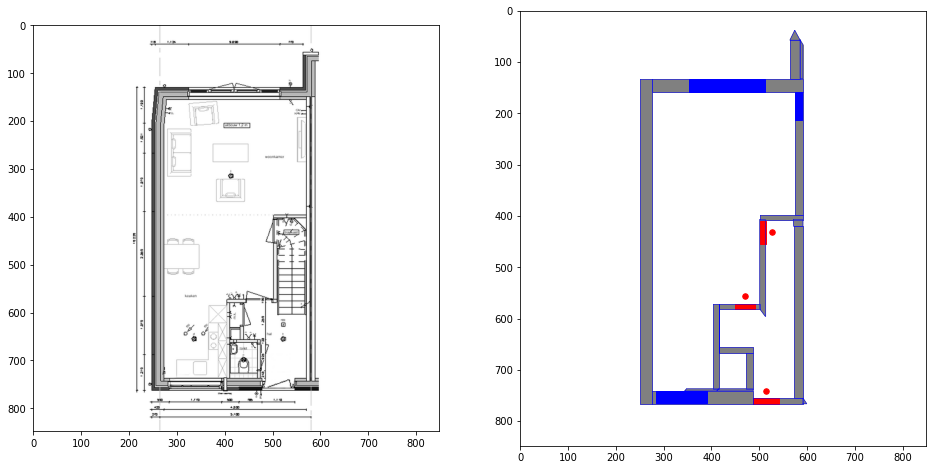

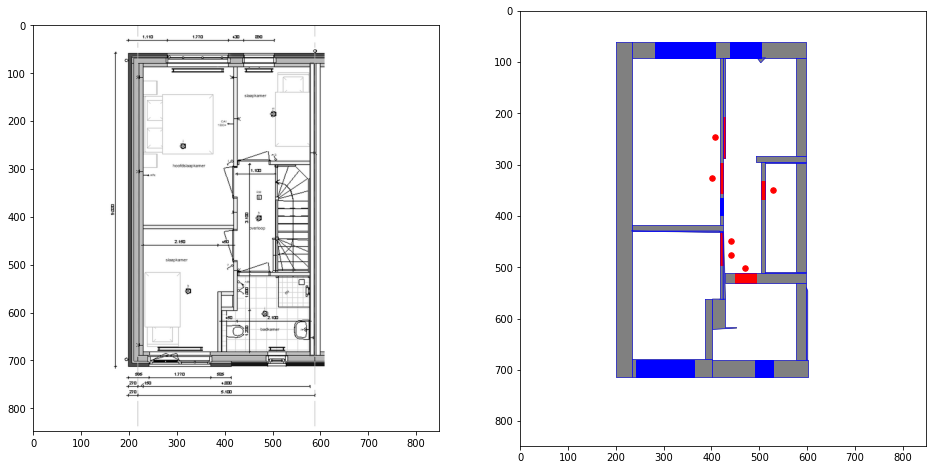

In [12]:
%%time

# BAG ID = 0164100000294714

for file_name in ['input/0164100000294714/1.png', 'input/0164100000294714/2.png']:
    processed = process_image(file_name)
    walls, openings, labels = processed['walls'], processed['openings'], processed['labels']

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.imshow(processed["input"], cmap="gray")
    for wall in walls: 
        ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1],color="grey")
        ax2.plot(wall.exterior.xy[0],wall.exterior.xy[1],color="blue",linewidth=0.5)

    for opening in openings:
        opening_poly = opening['polygon']
        ax2.fill(opening_poly.exterior.xy[0],opening_poly.exterior.xy[1],
                 color="red" if opening['type'] == "door" else "blue")

        center = opening_poly.centroid
        center = [center.xy[0][0], center.xy[1][0]]

        # direction: top, right, bottom, left
        if opening['direction'] != None:
            center[1] = center[1] - 20 if opening['direction'] == 0 else center[1]
            center[0] = center[0] + 20 if opening['direction'] == 1 else center[0]
            center[1] = center[1] + 20 if opening['direction'] == 2 else center[1]
            center[0] = center[0] - 20 if opening['direction'] == 3 else center[0]    

            ax2.scatter([center[0]], [center[1]],color="red", s=30)
    
    # Show final result
    ax1.set_ylim(image_size,0)
    ax2.set_ylim(image_size,0)
    ax2.set_xlim(0,image_size)
    
    
    with open(file_name[:-3]+"obj", 'wb') as filehandler:
        pickle.dump({
            "walls":walls,
            "openings":openings,
            "labels":labels
        }, filehandler)

    
    

0.995